# Bayesian Fitting Methods and MCMC

## Week 5, Intro-to-Astro 2020
### Written by Ryan Rubenzahl, 2020


## About this tutorial
In this tutorial you will use learn about Bayes theorem, how we use it to define the probability of a model given our data, and how we use different fitting methods to obtain the "best-fit" model. We'll also introduce the MCMC technique for determining not just the best-fitting model parameters, but the probability distribution of our model parameters given the data.


## Outline
1. Probability 101
2. Bayes Theorem
3. How we use Bayes' theorem for model fitting
    - Maximum likelihood and Maximum a-posteriori estimates
5. Computational methods for finding the maximum
6. MCMC

In [1]:
# allows us to see plots on the jupyter notebook
%matplotlib inline

# packages for plotting and numerical calculations
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# set matplotlib font
mpl.rc('font', family='sans serif', size=16)

# 1. Probability 101

First, let's have a quick review of some important concepts in probability. Probability is "the likelihood that something will happen." This could mean a coin has a 1 in 2 chance of landing on heads, a roll of a dice has a 1 in 6 chance of landing on a four, etc. You'll often see the following notation used:
$$ p(A | I) = 1/6 $$
This means that "the probability of event A, *given* prior information I, is 1 in 6."

The probability of event A AND event B happening is given by the **Product Rule**: 

$$ p(A, B|I) = p(A|B,I) \times p(B|I) $$

     - The probability of both A and B happening is equal to the probability that event B happens, then times the probability that, given B happened, A also happens.

**Example:** let there be two red marbles and one blue marble are in a bag. Two marbles are drawn from the bag in sequence and without replacement. What’s the probability that both marbles are red?
    
    - Our "information" is that we know there are two red marbles and one blue marble, so the probability of drawing red given this information is
$$ p(R|I) = 2/3 $$
    - Then for both marbles to be red, we use the product rule
    
$$ p(R, R | I) = p(R|I) \times p(R | R,I) = (2/3) \times (1/2) = 2/6 = 1/3 $$

Test

# 2. *The product rule allows us to derive Bayes' Theorem*

The probability of A and B happening is the same as the probability of B and A happening:

$$ p(A,B | I) = p(A|B,I) \times p(B|I) $$
$$ p(B,A | I) = p(B|A,I) \times p(A|I) $$

These are the same! Set equal and rearrange:

$$ \boxed{p(A|B,I) = \frac{p(B|A,I) \times p(A|I)}{p(B|I)} } $$

“The probability of A given B and I is equal to the probably of B given A times the probability of A irrespective of B, divided by the probability of B irrespective of A.”

### Assignment part 1: An example of Bayes' Theorem:

Suppose a disease exists in 1% of the population. A test has been developed, but it has a false-positive rate (positive reading when actually healthy) of 1%, and a false negative rate (negative reading when actually you have the disease) of 10%.

Say you had a positive test. What is the probability that you actually have the disease?

**We can use Bayes' theorem, where**

    A = have the disease
    
    B = had a positive test
    
Note that the denominator, $p(B|I)$, is the probability of having a positive test. We can write this out as

$$ p(B|I) = p(B,A|I) + p(B,\bar{A}|I) = p(B|A,I)p(A|I) + p(B|\bar{A},I) p(\bar{A}|I) $$

Remember, $I$ is just any information we might have (in this problem, it's the numbers that are given). We wrote out the denominator like this because now we can compute the probability of having a positive test directly from the true/false positive/negative rates, by looking at how likley a positive result comes back given either a patient who has the disease ($A$) OR a patient who doesn't have the disease ($\bar{A}$). When considering the probability of one thing OR another, we add (remember AND is multiply). So now, we have

$$ p(\text{disease} | +) = \frac{p(+ | \text{disease}) p(\text{disease})}{p(+|\text{disease})p(\text{disease}) + p(+|\text{no disease}) p(\text{no disease})} $$

In [3]:
false_neg = 0.10           # fraction of tests which read negative when the patient does have the disease
true_pos  = 1 - false_neg  # fraction of tests which read positive when the patient does have the disease 

false_pos = 0.01           # fraction of tests which read positive when the patient is indeed healthy
true_neg  = 1 - false_pos  # fraction of tests which read negative when the patient is indeed healthy

prob_have_disease = 0.01                  # fraction of the population that has the disease
prob_no_disease   = 1 - prob_have_disease # fraction of the population that is healthy

# Now, what is the probability of having the disease, given a postive test?
# Fill in the rest of the calculation here!
prob_pos=(true_pos*prob_have_disease)/((prob_have_disease*true_pos)+ (prob_no_disease*false_pos))
print("Probability of having the disease, given a postive test =", '{:.3f}%'.format(prob_pos*100))

Probability of having the disease, given a postive test = 47.619%


You should get about a 47.6% chance that, given a positive test result, you actually have the disease. Now, try it again with a false positive rate of 5% and a false negative rate of 1%. The probability wil drop to just 16.7% for having the disease given a positive test! This goes to show how important it is to have both a **sensitive** (good true positive) and **specific** (good true negative) test. These percentages are also quite low given the low prior probability of having the disease in the first place $p(\text{disease}) = 0.01$.

- Play around with the numbers and see how they change the result! How does it change if now 5% of the population has the disease? This is the power that priors can wield.

- What about the other way around? What is the probability you're "in the clear" if you get a negative test result back?

In [4]:
false_neg = 0.01           # fraction of tests which read negative when the patient does have the disease
true_pos  = 1 - false_neg  # fraction of tests which read positive when the patient does have the disease 

false_pos = 0.05           # fraction of tests which read positive when the patient is indeed healthy
true_neg  = 1 - false_pos  # fraction of tests which read negative when the patient is indeed healthy

prob_have_disease = 0.01                # fraction of the population that has the disease
prob_no_disease   = 1 - prob_have_disease # fraction of the population that is healthy

prob_pos=(true_pos*prob_have_disease)/((prob_have_disease*true_pos)+ (prob_no_disease*false_pos))
print("Probability of having the disease, given a postive test =", '{:.3f}%'.format(prob_pos*100))

Probability of having the disease, given a postive test = 16.667%


In [5]:
false_neg = 0.10           # fraction of tests which read negative when the patient does have the disease
true_pos  = 1 - false_neg  # fraction of tests which read positive when the patient does have the disease 

false_pos = 0.01           # fraction of tests which read positive when the patient is indeed healthy
true_neg  = 1 - false_pos  # fraction of tests which read negative when the patient is indeed healthy

prob_have_disease = 0.01                # fraction of the population that has the disease
prob_no_disease   = 1 - prob_have_disease # fraction of the population that is healthy

prob_pos=(true_pos*prob_have_disease)/((prob_have_disease*true_pos)+ (prob_no_disease*false_pos))
prob_neg=(prob_no_disease*false_pos)/((prob_have_disease*true_pos)+ (prob_no_disease*false_pos))
print("Probability of not having the disease, given a postive test =", '{:.3f}%'.format(prob_neg*100))
print("Probability of not having the disease, given a postive test =", '{:.3f}%'.format((1-prob_pos)*100))

Probability of not having the disease, given a postive test = 52.381%
Probability of not having the disease, given a postive test = 52.381%


In [6]:
false_neg = 0.01           # fraction of tests which read negative when the patient does have the disease
true_pos  = 1 - false_neg  # fraction of tests which read positive when the patient does have the disease 

false_pos = 0.05           # fraction of tests which read positive when the patient is indeed healthy
true_neg  = 1 - false_pos  # fraction of tests which read negative when the patient is indeed healthy

prob_have_disease = 0.01                # fraction of the population that has the disease
prob_no_disease   = 1 - prob_have_disease # fraction of the population that is healthy

prob_neg=(true_pos*prob_have_disease)/((prob_have_disease*true_pos)+ (prob_no_disease*false_pos))
print("Probability of having the disease, given a postive test =", '{:.3f}%'.format(prob_pos*100))

Probability of having the disease, given a postive test = 47.619%


# 3. In the context of model fitting, we call A the "hypothesis" ($H$) and B the "data" ($D$)

![Bayes Theorem](Bayes-theorem.png)

## How do we use Bayes' Theorem for model fitting?

Let's say we have some measured data $D = (x, y)$, and it looks like there is a linear relationship between x and y.

In [43]:
a_true = 4.1; b_true = 2.14; # True parameters of the underlying model

# Make some "fake" data
N = 30
x = np.random.uniform(0, 10, N) # some random points in x (uniformly spaced to N data points)
yerr = 5 # our measurement uncertainty on our y measurements
error = yerr*np.random.normal(0, 1, N) # assume our error is Gaussian
y = a_true*x + b_true + error # fake observations of "y" at each "x"

#Making a baseline line of y=mx+c 
#where xs are regularly intervaled points from 0 to 10 (which is the domain of Data's x, distributed normally)
#m and c are a_true and b_true, which are also used in creating the y of our data D
#ys are the corresponding y terms, without errors (as used in x)
xs = np.linspace(0, 10, 1000) 
ys = a_true*xs + b_true

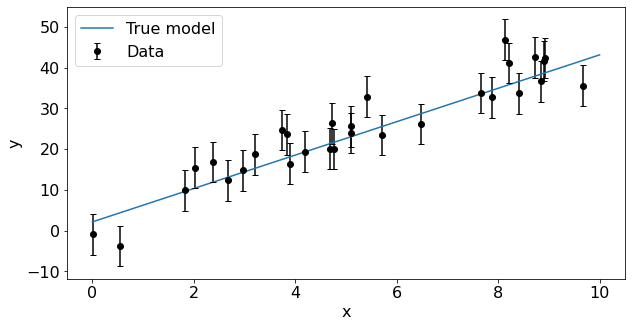

In [44]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.plot(xs, ys, label='True model')
ax.errorbar(x, y, yerr=yerr, fmt='o', capsize=3, color='k', label='Data')
ax.set(xlabel='x', ylabel='y'); ax.legend()

We might make a hypothesis $H$ that “the data were generated by a function $f(x) = a x + b.$” In this case, our "model parameters" are the slope $a$ and the intercept $b$.

In this case, $p(H|D,I) = p(a,b|(x,y),I)$ gives the probability that hypothesis $H$ generated the data, given our measurements $x$ and $y$.

- The **likelihood** $p(D|H,I) = p(x,y|a,b,I)$ tells us, given our model, how likely it was for us to measure the data we did. This is usually easy to calculate, e.g. if we assume our data points are "Gaussian", then our mean is the expected value predicted by the model and the error in our measurement is the standard deviation, and we can use the equation describing a Gaussian (https://en.wikipedia.org/wiki/Normal_distribution) to calculate that probability of finding the value that we did.

- The **prior** p(H|I) is not always obvious. In our example, the prior is $p(H|I) = p(a,b|I) = p(a|b,I)p(b|I)$. Sometimes we use an "uninformative" prior and simply say that all possible values of our $a$ and $b$ are equally likely, but if we have reason to believe that the slope of our data ($a)$ is close to some value, or even that it depends in some way on $b$ (or vice-versa), perhaps from another observation or some theoretical expectation, then we can use that to inform the posterior!


- The **evidence** is the probability of measuring our data, regardless of the hypothesis $H$. We don't really know how to calculate this, but luckily it isn't important; since it doesn't depend on the model parameters (only on the data), and what we're interested in is finding the best-fitting values of the model, it doesn't affect the optimization. (extra detail: we can simply normalize the numerator and divide by that normalization factor instead).

## Aside: What is the meaning of an "error bar"

This depends on whether we are adopting a "frequentist" or "Bayesian" philosphy:

- The frequentist assumes the true value is a fixed value, assigned by Nature. When we measure that value, we find something near to the true value at some probability. **The frequentist uses the likelihood, p(D|H,I).** The true parameter is "fixed" and it is the data that are observed with some probability.


- The Bayesian assumes that the measured uncertainty tells us that the true value lies somewhere nearby the measured value at some probability. **The Bayesian uses the posterior, p(H|D,I).** The observed data are "fixed" and it is the true parameter which is determined with some probability. The Bayesian can incorporate prior knowledge into determining the probability with which the true value is actually near the measured data.

https://xkcd.com/1132/

In [48]:
from scipy.stats import norm



def make_frequentist_bayesian_plot(x, true_mean, measured_mean, std_dev):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5), sharex=True, sharey=True)
    
    ax1.plot(x, norm(true_mean, std_dev).pdf(x), color='k', label='Likelihood')
    ax1.axvline(measured_mean, color='C0', ls='--', label='Measured')
    ax1.axvline(true_mean,    color='C1', ls='--', label='Truth')
    ax1.errorbar([measured_mean], [0.45], xerr=std_dev, color='C0', fmt='o', capsize=3)
    ax1.set_title('Frequentist')

    ax2.plot(x, norm(measured_mean, std_dev).pdf(x), color='k', label='Posterior')
    ax2.axvline(measured_mean, color='C0', ls='--', label='Measured')
    ax2.axvline(true_mean,    color='C1', ls='--', label='Truth')
    ax2.errorbar([measured_mean], [0.45], xerr=std_dev, color='C0', fmt='o', capsize=3)
    ax2.set_title('Bayesian')
    
    ax1.set(xlabel='True Parameter value (Already known)', ylabel='Probability')
    ax2.set(xlabel='Assumed Parameter value (Predictive model)'); ax1.legend(loc='upper left'); ax2.legend(loc='upper left')

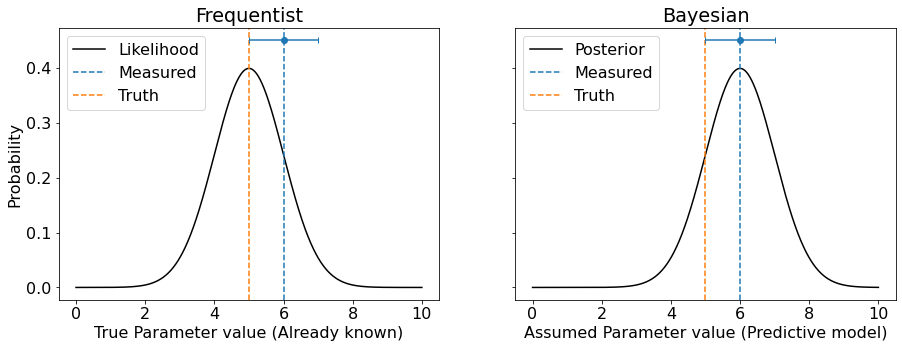

In [49]:
data_x=np.linspace(0, 10, 1000)
true_mean = 5
measured_mean = 6
std_dev = 1
make_frequentist_bayesian_plot(data_x, true_mean, measured_mean, std_dev)

## Now, let's see what this looks like for our example data

In [50]:
def log_likelihood_of_point(x, y, a, b):
    '''
    Return the log likelihood of measuring the value y 
    at position x, given the model parameters a and b,
    assuming a Gaussian distribution
    '''
    
    mu = a*x + b # the mean is the expected value of y as predicted by the model
    sd = yerr    # standard deviation = measurement error in y
    
    return np.log(1/np.sqrt(2*np.pi*sd**2)) - (y - mu)**2 / (2*sd**2) # Formula for a Gaussian 
    #Since we are using log likelihood, we applied log on both sides of the probability distribution function formula

In [51]:
# Calculate this for the fourth data point
log_likelihood_of_point(x[4], y[4], a_true, b_true)

-2.6596416392957765

To get the total likelihood, we multiply the probability for every data point together. Since (for computational reasons) we usually work with the log of the likelihood, multiplying turns into adding (rules of logarithms):

In [52]:
def log_likelihood(params):
    a, b = params # we have to write it like this in order to pass into scipy.optimize.minimize and emcee later
    return np.sum([log_likelihood_of_point(xx, yy, a, b) for (xx, yy) in zip(x, y)], axis=0)

Now we can plot what the likelihood looks like for different values of $a$ and $b$. First, let's just do it for $a$, holding $b$ to the true value for illustrative purposes.

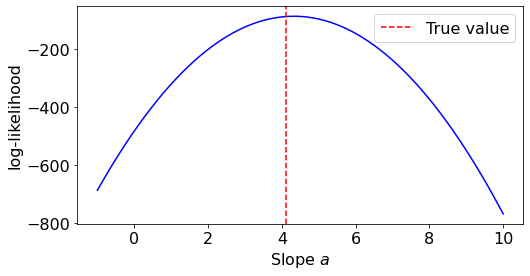

In [53]:
fig, ax = plt.subplots(1,1, figsize=(8,4))

b = b_true
a = np.linspace(-1, 10, 1000) # try a range of slopes

ax.plot(a, [log_likelihood([a_value, b]) for a_value in a], color='b')
ax.axvline(a_true, ls='--', color='r', label='True value')

ax.set(xlabel=r'Slope $a$', ylabel='log-likelihood')
ax.legend();

### Really, we want to look in 2D

To do that, let's make a contour plot of the slope and intercept. This is like a topographic map of the likelihood.

In [54]:
aa = np.linspace(2, 6)
bb = np.linspace(-5, 10, 1000) 
A, B = np.meshgrid(aa, bb)

real_max_llh = log_likelihood([a_true, b_true])
LLH = real_max_llh - log_likelihood([A, B])

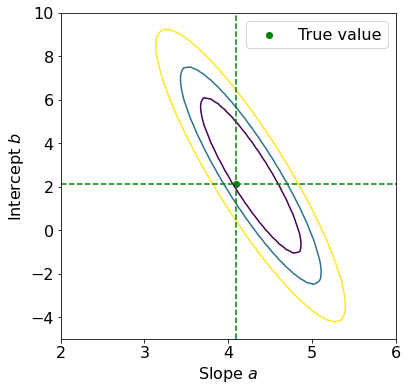

In [55]:
fig, ax = plt.subplots(1,1, figsize=(6,6))
cs = ax.contour(A, B, LLH, levels=[0.5, 2, 4.5])
ax.scatter([a_true], [b_true], color='g', label='True value')
ax.axvline(a_true, color='g', ls='--'); ax.axhline(b_true, color='g', ls='--')
ax.set(xlabel=r'Slope $a$', ylabel='Intercept $b$')
ax.legend(loc='best')

### Our goal of finding the "best-fit" value of $a$ and $b$ is obtained by *maximizing the a-posterior probability*

In other words, maximizing the likelihood times the priors. We're basically saying 

> What properties of our hypothesized model $H$ (i.e. what values of $a$ and $b$) are **most probable** given the data that we observed?

If all of our priors are "uniform," then the maximum a-posteriori (MAP) estimate is the same as the maximum likelihood (ML) estimate, because we're just multiplying by a constant!

### Assignment part 2: 
Write a function to define a "uniform" prior that is bounded a $\texttt{lower}$ and $\texttt{upper}$ value. A "uniform" prior is one which has equal probability at all values. Outside of the bounds, the prior should return 0 probability (or $-\infty$ if written as a log-prior), and in between the bounds it should return a constant value. The constant can be determined by making sure the total probability (area under the curve) equals 1.

Then, define a log_posterior function which returns the sum of the log_likelihood function above and the log_prior you defined.

# 4. How do we maximize the posterior?

Next, let's look at how we can find the maximum of this function. We could see it by eye, in the previous examples (the top of the hill in the contour plot), but if your problem has 10+ different parameters, it won't be so easy to see. This is where the power of computers comes in.

Most computer code is written to actually find the *minimum* of a function, rather than the maximum. This is no problem, we can simply minimize the *negative* of our function to get the maximum. You'll often see people talk about the "negative log likelihood" in this context.

<img src="gradient_descent.png" width="300"/>

In [12]:
from scipy.optimize import minimize

def neg_log_likelihood(params):
    return -log_likelihood(params)

init_params = [0, 0] # initial values of a and b

sol = minimize(neg_log_likelihood, init_params, method='Nelder-Mead')
sol

 final_simplex: (array([[4.01954548, 3.58708284],
       [4.01953801, 3.58711331],
       [4.01955353, 3.58698464]]), array([94.36709931, 94.36709931, 94.36709931]))
           fun: 94.36709931183688
       message: 'Optimization terminated successfully.'
          nfev: 167
           nit: 89
        status: 0
       success: True
             x: array([4.01954548, 3.58708284])

## Let's plot the maximum likelihood solution!

In [13]:
aa = np.linspace(2, 6)
bb = np.linspace(-5, 10, 1000) 
A, B = np.meshgrid(aa, bb)

real_max_llh = log_likelihood([a_true, b_true])
LLH = real_max_llh - log_likelihood([A, B])

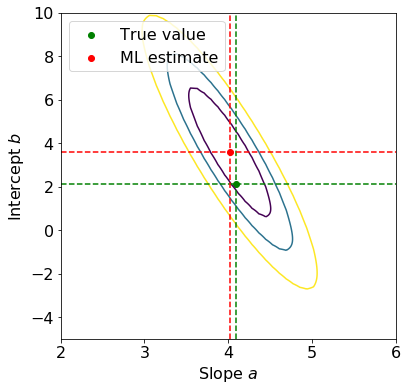

In [14]:
# Unpack the maximum likelihood solution for a and b
a_ml, b_ml = sol.x

fig, ax = plt.subplots(1,1, figsize=(6,6))
cs = ax.contour(A, B, LLH, levels=[0.5, 2, 4.5])
ax.scatter([a_true], [b_true], color='g', label='True value')
ax.axvline(a_true, color='g', ls='--'); ax.axhline(b_true, color='g', ls='--')

ax.scatter([a_ml], [b_ml], color='r', label='ML estimate')
ax.axvline(a_ml, color='r', ls='--'); ax.axhline(b_ml, color='r', ls='--')
ax.set(xlabel=r'Slope $a$', ylabel='Intercept $b$')
ax.legend(loc='best')

## With our maximum likelihood estimate, we can plot our "best-fit" model

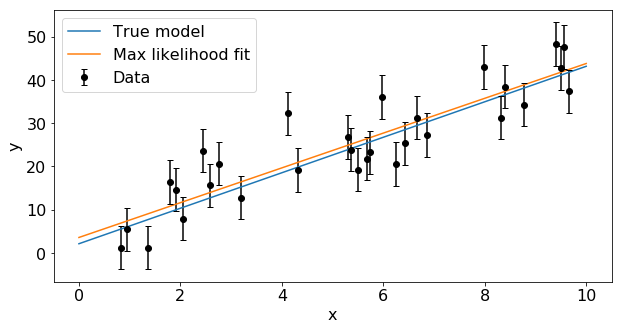

In [15]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.plot(xs, ys, label='True model')
ax.plot(xs, a_ml*xs + b_ml, label='Max likelihood fit')
ax.errorbar(x, y, yerr=yerr, fmt='o', capsize=3, color='k', label='Data')
ax.set(xlabel='x', ylabel='y'); ax.legend()

### Assignment part 3: 
1. Using the log_posterior function you defined, write a `neg_log_posterior` function similar to the one for `neg_log_likelihood` that is compatible with `scipy.optimize.minimze`.

2. Then minimize it and print out the best-fit solutions. How do they compare to what we found using the likelihood? 

3. How does changing the prior (define a different function, or change the bounds!) affect the solution? 

4. How does changing the initial guess affect the solution?

# 5. Markov-Chain Monte Carlo (MCMC)

Not every problem is as simple as our example linear model, which only has two dimensions (slope and intercept). In reality, models can consist of many parameters. An example you'll see later is a radial velocity model, which has 5 parameters *per planet*!

Numerical functions for finding the MAP estimate are good, but they also don't show us the **shape** of the posterior itself. We not only want to know what the best-fit parameters are, but we'd also ideally like to know what the *uncertainty* in those best-fit parameters are. While some maximization algorithms can provide estimates for the error in the best-fit parameters, not all can.

Often, our posterior is not a perfect Gaussian like we often pretend it is. Why do we care about the shape? This gives us the most information as to what the **distribution** of possible parameter values is, and at what probability they are consistent with the data. This is much more powerful than saying our slope is $4 \pm 1$ (which implies a Gaussian with a mean of 4 and a standard deviation of 1). This is what MCMC gives us: the shape of the posterior, which tells us what the probability distribution of each model parameter looks like.

### Some resources on MCMC

- A zero-math intro to MCMC: https://towardsdatascience.com/a-zero-math-introduction-to-markov-chain-monte-carlo-methods-dcba889e0c50

- MCMC visualized: https://elevanth.org/blog/2017/11/28/build-a-better-markov-chain/

- `emcee` tutorial: https://emcee.readthedocs.io/en/stable/tutorials/line/

### How does MCMC work?

"Random" walk through the posterior "surface"

<img src="mcmc-walkers.png" width="600"/>

In [25]:
import emcee

Ndim     = 2    # How many free parameters there are (we have 2 variables, a and b)
Nwalkers = 16   # How many "walkers" are wandering around the "parameter space" mapping out the posterior 
Nsteps   = 5000 # How many steps should each walker take?

# We have to start of the walkers somewhere, so let's just give it a starting point of a=6, b=10.
pos = np.array([6, 10]) + 1e-4 * np.random.randn(Nwalkers, Ndim)

# Create the "emcee" sampler and set the walkers loose!
sampler = emcee.EnsembleSampler(Nwalkers, Ndim, log_likelihood)
sampler.run_mcmc(pos, Nsteps, progress=True);

100%|██████████| 5000/5000 [00:14<00:00, 339.45it/s]


### Let's see how the walkers wandered around the parameter space

In [26]:
samples = sampler.get_chain()

a_samples = samples.T[0]
b_samples = samples.T[1]

aa = np.linspace(1, 7)
bb = np.linspace(-10, 15, 1000) 
A, B = np.meshgrid(aa, bb)

real_max_llh = log_likelihood([a_true, b_true])
LLH = real_max_llh - log_likelihood([A, B])

[(-10, 15), Text(0, 0.5, 'Intercept $b$'), (1, 7), Text(0.5, 0, 'Slope $a$')]

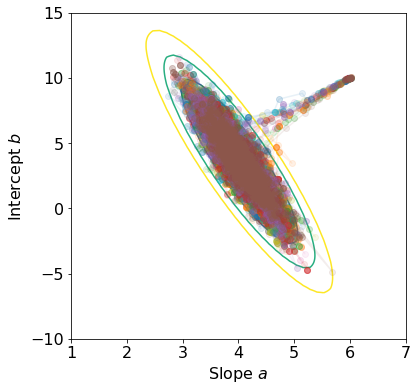

In [27]:
fig, ax = plt.subplots(1,1, figsize=(6,6,))

cs = ax.contour(A, B, LLH, levels=[0.5, 2, 4.5, 8, 12.5])
ax.scatter([a_true], [b_true], color='g', label='True value')
ax.scatter([a_ml], [b_ml], color='r', label='ML estimate')

for w in range(Nwalkers): # MCMC steps
    ax.plot(a_samples[w], b_samples[w], 'o-', alpha=0.1)

ax.set(xlim=[1,7], ylim=[-10,15], xlabel=r'Slope $a$', ylabel='Intercept $b$')

We can see that the walkers started at (6,10) and took some time to wander over towards the main "oval", at which point they did a nice job of filling in the shape of the posterior surface.

We can see this initial "convergence" phase if we simply plot all the walkers positions as a function of time:

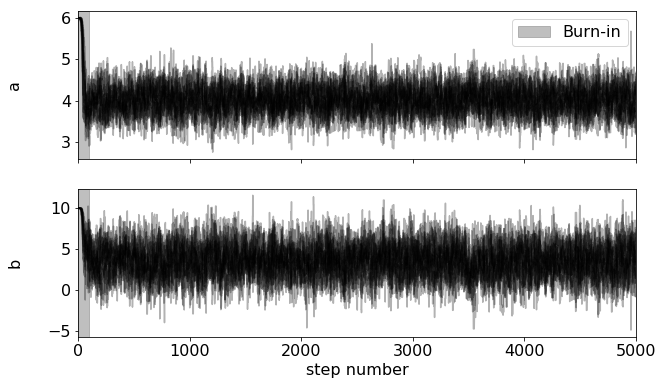

In [28]:
fig, axes = plt.subplots(2, figsize=(10, 6), sharex=True)

labels = ["a", "b"]

for i in range(Ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    ax.axvspan(0, 100, color='grey', alpha=0.5, label='Burn-in')
    
axes[0].legend(loc='upper right')
axes[-1].set_xlabel("step number");

The above is called a "trend plot" and can clearly show this "burn-in" region (the first ~200 steps) before the walkers are actually exploring the shape of the posterior around the maximum. Because these burn-in samples aren't representative samples of the full shape of the posterior, we usually throw them out and only start counting samples once the walkers have converged a bit (there's lots of fancy math ways to calculate when you get to that point).

A way of avoiding the burn-in is to instead start-off the walkers at the maximum-likelihood esimate we found before. If we have reason to believe that this estimate is indeed near the true maximum, then we can basically skip the (or otherwise have a much shorter) burn-in phase altogether.

### Assignment part 4:

1. Change the initial position of the MCMC walkers to be the maximum-likelihood (or MAP) estimate you found earlier. (Basically, change the random point we set `[6, 10]` to be `sol.x`).

2. Inspect how the convergence of the burn-in phase changes.

## The "Corner" plot: modern art

A corner plot takes the contour plot we made above a step further and tailors it to our MCMC output. What this plot shows is the MCMC samples for each pair of parameters in our model, as well as the 1-D histograms for each parameter itself. This is the ultimate "summary" plot of our model fit. It shows, for each parameter in our model, what the MCMC-estimated probability distribution is for each parameter, as constrained by the data.

You can make corner plots using the `corner.py` module: https://corner.readthedocs.io/en/latest/

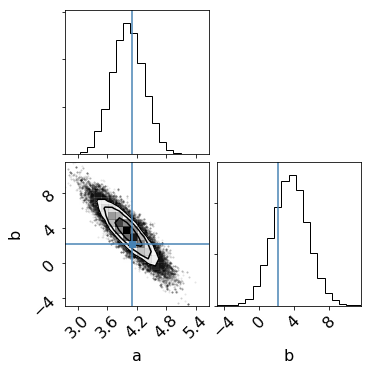

In [30]:
import corner

# Combine all walkers together (and throw away the burn-in steps)
burnin = 200
flat_samples = sampler.get_chain(discard=burnin, flat=True)

fig = corner.corner(flat_samples, labels=labels, truths=[a_true, b_true]);

## The grand finale: Plotting our "best-fit" *distribution* of models from the MCMC

Since the MCMC gives us a range of possible parameter models, and each step in the MCMC is a "sample" from the posterior, we can pick random MCMC samples of our parameters with the same probability that they generated the data, and plot a bunch of these together to give a better sense of "what range of models are consistent (statistically) with the data."

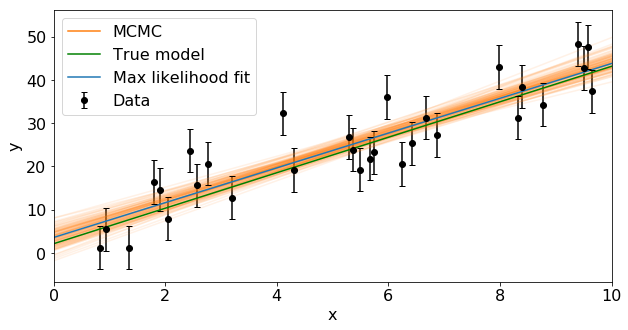

In [31]:
fig, ax = plt.subplots(1,1, figsize=(10,5))

# Plot random draws from the MCMC
inds = np.random.randint(len(flat_samples), size=100)
label = 'MCMC'
for ind in inds:
    (a_mcmc, b_mcmc) = flat_samples[ind]
    ax.plot(xs, a_mcmc*xs + b_mcmc, color="C1", alpha=0.1, label=label)
    label = None
    
# Show the true model and max-likelihood fit for reference
ax.plot(xs, ys, label='True model', color='green')
ax.plot(xs, a_ml*xs + b_ml, label='Max likelihood fit', color='C0')

# Plot the data
ax.errorbar(x, y, yerr=yerr, fmt='o', capsize=3, color='k', label='Data')
ax.set(xlabel='x', ylabel='y', xlim=[0,10]); leg = ax.legend()
for lh in leg.legendHandles: 
    lh.set_alpha(1)